## Lightgbm Regerssor
- 목적
    - Lightgbm sklearn API 활용
- 참고 자료
    - [CatBoost vs. Light GBM vs. XGBoost
](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from lightgbm import LGBMRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nyc-taxi-demand'

In [2]:
ex = Experiment('nyc-taxi-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [3]:
%%time
query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=query, dialect='standard', project_id=PROJECT_ID)

Downloading: 100%|██████████████████| 87020/87020 [00:07<00:00, 11514.49rows/s]

Wall time: 30.2 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [4]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [5]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : 기간(정수 값, ex) 3 -> 3일)
    """
    criteria = max(df['pickup_hour']) - pd.Timedelta(days=period)  # 기준 일 계산
    train_df = df[df['pickup_hour'] <= criteria]
    test_df = df[df['pickup_hour'] > criteria]
    return train_df, test_df

### Train / Test 나누기

In [6]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [7]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
68046,10452,2015-01-24 23:00:00,1,24,5,23,1,1,81
68047,11378,2015-01-24 23:00:00,1,24,5,23,1,1,251
68048,10701,2015-01-24 23:00:00,1,24,5,23,1,1,142
68049,11373,2015-01-24 23:00:00,1,24,5,23,1,10,247
68050,11209,2015-01-24 23:00:00,1,24,5,23,1,5,198


- 사용하지 않을 컬럼 삭제

In [8]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [9]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [10]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [11]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [12]:
@ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [13]:
@ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [14]:
@ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)    # lightgbm 회귀 모델 적합
    lgbm_pred = lgbm_reg.predict(x_test)  # 모델 예측
    score = evaluation(y_test_raw, lgbm_pred)  # 모델 성능 평가
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    # 모델 이름 저장(metrics.json)
    _run.log_scalar('metrics', score)  # 모델 성능 저장(metrics.json)
    
    return score.to_dict()

In [15]:
experiment_result = ex.run()

INFO - nyc-taxi-demand-prediction - Running command 'run'
INFO - nyc-taxi-demand-prediction - Started run with ID "4"
INFO - nyc-taxi-demand-prediction - Result: {'mape': {'score': 390.90254866574725}, 'mae': {'score': 49.9020413619915}, 'mse': {'score': 14720.280972352346}}
INFO - nyc-taxi-demand-prediction - Completed after 0:00:01


In [16]:
experiment_result.config

{'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'seed': 732891447}

In [17]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

    
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.read_csv(StringIO(json_data['metrics']['values'][0]['values']), sep=',|\r\n')
    metric_df.index = ['score']

    
    output_df = pd.concat([output_df, metric_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [18]:
parsing_output(4)

,model_name,experiment_num,config,mape,mae,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",390.9,49.9,14720.28


In [19]:
# xgboost model 성능
parsing_output(3)

,model_name,experiment_num,config,mape,mae,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",505.27,57.07,16388.44


- 기본 파라미터 값을 적용한 xgboost 모델에 비해, 기본 파라미터 값을 적용한 lightgbm 모델 성능이 약간 좋은 것을 확인

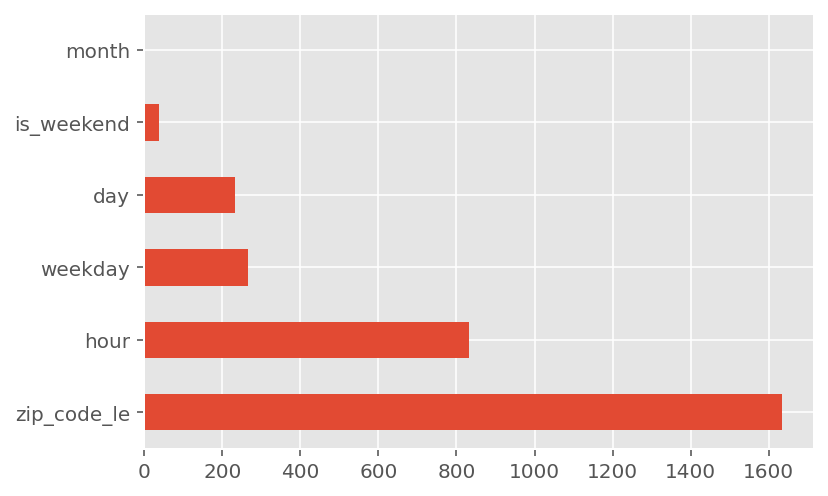

In [20]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')